In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


임의의 time series data 생성

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

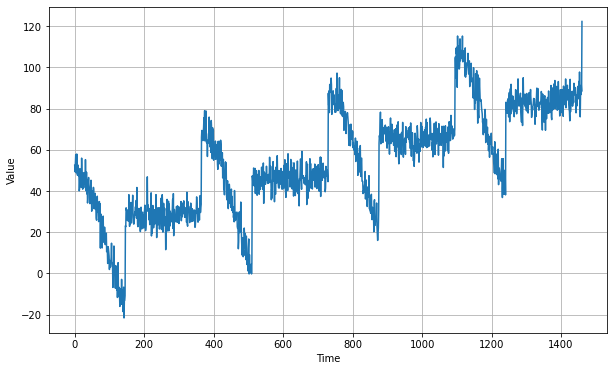

In [5]:
plt.figure(figsize=(10,6))
plot_series(time , series)

In [6]:
# 생성한 데이터를 train 과 valid로 분할
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation ="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [16]:
# callback 함수에서 자동으로 learning rate를 변경하게끔 만들어 줌.
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8*10**(epoch/20)
)
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer = optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 1575.1215
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 888.2164
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 491.1145
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 291.6238
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 196.4395
Epoch 6/100
31/31 [==============================] - 0s 997us/step - loss: 152.2217
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 131.8456
Epoch 8/100
31/31 [==============================] - 0s 933us/step - loss: 121.7724
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 117.1255
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 114.8578
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 113.6623
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 112.9464
Epoch 13

31/31 [==============================] - 0s 933us/step - loss: nan
Epoch 100/100
31/31 [==============================] - 0s 1ms/step - loss: nan


learning rate 와 loss의 그래프를 보면
loss가 가장 작아질때의 lr을 구할 수 있다.
여기선 대략 8*e-6

(1e-08, 0.001, 0.0, 300.0)

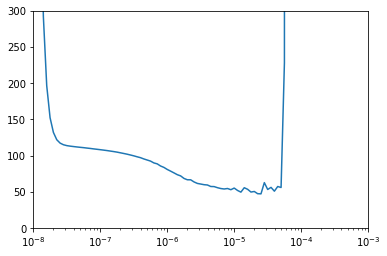

In [17]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [18]:
#최적의 lr을 적용해서 다시 트레이닝
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

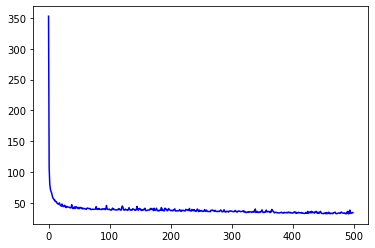

In [23]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[54.77770233154297, 51.93580627441406, 52.26030349731445, 51.803524017333984, 49.13740921020508, 48.81900405883789, 47.58413314819336, 49.39051818847656, 49.67121887207031, 46.31685256958008, 45.3729362487793, 44.504886627197266, 48.10067367553711, 44.77288818359375, 44.22380447387695, 43.98601150512695, 46.01646423339844, 45.514984130859375, 42.769554138183594, 42.378414154052734, 44.36530685424805, 43.447410583496094, 43.091670989990234, 43.027992248535156, 42.93815231323242, 41.953948974609375, 41.816410064697266, 42.88369369506836, 47.0162239074707, 41.18508529663086, 41.455406188964844, 40.685203552246094, 43.205345153808594, 40.86056137084961, 43.42837142944336, 41.809200286865234, 43.4409065246582, 41.688011169433594, 40.99930191040039, 42.5771598815918, 40.379783630371094, 42.139892578125, 42.5819206237793, 41.75450134277344, 40.659576416015625, 41.786869049072266, 40.0892219543457, 40.6691780090332, 41.12411880493164, 40.3447151184082, 40.18431854248047, 40.05390167236328, 39.

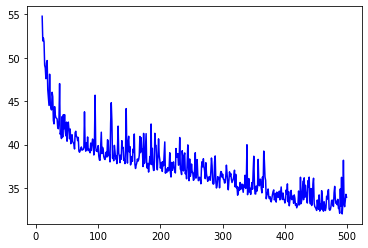

In [24]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [19]:
forecast = []

for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))


In [20]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


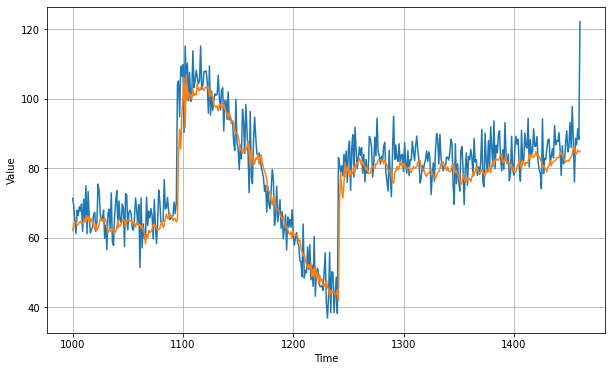

In [21]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.078787